I followed this [tutorial](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/), but couldn't replicate it because [Gym (OpenAI)](https://www.gymlibrary.dev/) was updated, and several parts of the code were changed, so I made this notebook. Here is the updated tutorial's code; you can run it in Kagle or Colab without problems.

For the code to run in both Colab and Kaggle, it is necessary to have Gym at version 0.25.2 since, by default, Kaggle installs it at version 0.23.1.

In [1]:
!pip install gym[toy_text]==0.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.5/734.5 kB 11.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 55.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.25.2-py3-none-any.whl size=852300 sha256=53187680b1e880c0b7a24152af383b39a615d110dece07e421d7b44faaeda49a
  Stored in directory: /root/.cache/pip/wheels/d9/f5/85/b1d12cbec459c46b7e13e86c58cf5d94368761c41585215a1d
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.23.1
    Uninstalling gym-0.23.1:
      Successfully uninstalled gym-0.23.1


Import libraries...

In [2]:
from time import sleep
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import gym

...and validate Gym version

In [4]:
gym.__version__

'0.25.2'

To see the game environment in graphical mode, the *render_mode* in *rgb_array* must be used. I won't work with this option, but I'll leave it if you prefer.

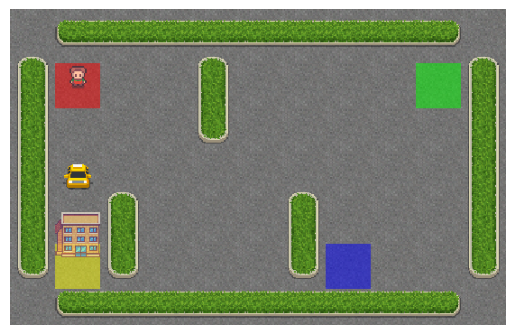

In [5]:
env = gym.make("Taxi-v3", render_mode ='rgb_array', new_step_api=True).env

env.reset()
img = env.render()
plt.imshow(img[0])
plt.axis('off')
plt.show()

In our case, we will use ANSI mode, which allows viewing through characters.

In [6]:
env = gym.make("Taxi-v3", render_mode ='ansi', new_step_api=True).env

In [7]:
env.reset()
print(env.render()[0])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [8]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


In [9]:
env.reset()
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
print(env.render()[0])

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




The reward table is assigned to state 328, which we defined earlier.

In [10]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In the following, the part of the env. step was modified, which now returns a boolean variable that is 'truncated'; it tells us if the execution is terminated because it enters a restriction (it is not our case).

In [11]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False


while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 264
Penalties incurred: 90


This function allows us to visualize the frames we have saved; we only have to give as parameters the list of frames we collect (*frames*) and the time to visualize one frame to another (*time_sleep*).

In [12]:
def print_frames(frames, time_sleep = .1):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'][0])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(time_sleep)

In [13]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 264
State: 0
Action: 5
Reward: 20


# Q-Learning

In [14]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Training the Agent

In [15]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, truncated, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: user 2min 15s, sys: 16.2 s, total: 2min 31s
Wall time: 2min 20s


Q-values in our state

In [16]:
q_table[328]

array([ -2.41217969,  -2.27325184,  -2.40926051,  -2.36178282,
       -10.42022258, -11.09424808])

Evaluating the Agent

In [17]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100
frames =[]

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, truncated, info = env.step(action)

        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.31
Average penalties per episode: 0.0


So that you can see the movements of the game clearly, I recommend that you try with the time_sleep above 0.3

In [18]:
print_frames(frames, .1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1331
State: 0
Action: 5
Reward: 20


Here I leave some resources that they reviewed to be able to run the code of the tutorial.

* [Video Tutorial](https://www.youtube.com/watch?v=4D-dQmIx_r0)
* [Game information](https://www.gymlibrary.dev/environments/toy_text/taxi/)
* [Environment documentation](https://www.gymlibrary.dev/api/core/)
* [Another Tutorial](https://www.kaggle.com/code/parisanahmadi/ml-reinforcement-learning-taxiv3)